# in this notebook

Evaluating the full Lyapunov spectra of the rotating wave phenomena.

Based on the Jupyter Notebook 2016-10-27-LP-Lyapunov-spectra-coupled-systems.



# Setup
## Loading simulation parameters

In [19]:
Coup_scheme='XYZ' # change here to 'XYZ', 'X', 'Y' or 'Z'
#####################

LoadFile='DATA_HUGE_CoupTru_'+Coup_scheme+'_Hildas_PRE_6Rosslers_Ci0_Cf0_2step0_001_Ttime30000'
PathLoadFile=r'/media/leo/76E45D14E45CD7C7/BigData/RotatingWaves/Rossler/2016-08-26-arquive-Manipulating-Coupling/Coupling-tru-'+Coup_scheme


In [24]:
# Loading data poincare section
DataFile=h5py.File(PathLoadFile+r'/'+LoadFile+'.hdf5', "r") # creating a file

# Initializing some variables
#Coup_list=DataFile.attrs['Coupling force list']
Coup_list_keys=DataFile.keys()#s_time=MyFile.attrs['Sampling Time (s)']
args_n=DataFile.attrs['System parameters (a,b,c)']
H=Matrix(DataFile.attrs['Coupling through (x,y,z):'].astype('int'))
Nsys=DataFile.attrs['Frequencies'].shape[0]
N_coup=len(Coup_list_keys)

#Vendo os atributos
print '\n - Atributos do arquivo: \n', DataFile.attrs.items()

#DataFile.close()


 - Atributos do arquivo: 
[(u'System parameters (a,b,c)', array([ 0.45,  2.  ,  4.  ])), (u'Frequencies', array([ 1.,  1.,  1.,  1.,  1.,  1.])), (u'Integration Time (s)', 0.01), (u'Sampling Time (s)', 0.01), (u'Sampling frequency (Hz)', 100.0), (u'Time length+transient (s)', 30000.0), (u'Time length (s)', 30000.0), (u'Transient (s)', 0.0), (u'Data shape', nan), (u'Coupling force list', array([ 0.   ,  0.001,  0.002,  0.003,  0.004,  0.005,  0.006,  0.007,
        0.008,  0.009,  0.01 ,  0.011,  0.012,  0.013,  0.014,  0.015,
        0.016,  0.017,  0.018,  0.019,  0.02 ,  0.021,  0.022,  0.023,
        0.024,  0.025,  0.026,  0.027,  0.028,  0.029,  0.03 ,  0.031,
        0.032,  0.033,  0.034,  0.035,  0.036,  0.037,  0.038,  0.039,
        0.04 ,  0.041,  0.042,  0.043,  0.044,  0.045,  0.046,  0.047,
        0.048,  0.049,  0.05 ,  0.051,  0.052,  0.053,  0.054,  0.055,
        0.056,  0.057,  0.058,  0.059,  0.06 ,  0.061,  0.062,  0.063,
        0.064,  0.065,  0.066,  0.067,  0

### Reordering state vector:
 * Original data format: ['x1' 'x2' 'x3' 'y1' 'y2' 'y3' 'z1' 'z2' 'z3'] 
 * Format used in the Lyapunov function: ['x1' 'y1' 'z1' 'x2' 'y2' 'z2' 'x3' 'y3' 'z3']
 
> xData=np.array([i+str(j) for i in ['x', 'y', 'z'] for j in range(1,4)])

> print xData

> print xData.reshape((3,3)).T.ravel()

## Symbolic vectors and matrices

In [27]:
Vars=['x','y','z']

sys_i=[str(i) for i in np.arange(1,Nsys+1)]

labels_temp=[j+i+' ' for i in sys_i for j in Vars]
labels_temp='None '+''.join(labels_temp) # none para que X[1] corresponda ao simbolo x1
#print labels_temp

# state variables
X=symbols(labels_temp, real=True)
vecX=Matrix(X[1:])

vecX.T

[x₁  y₁  z₁  x₂  y₂  z₂  x₃  y₃  z₃  x₄  y₄  z₄  x₅  y₅  z₅  x₆  y₆  z₆]

In [28]:
# Symbolic parameters
a,b,c=symbols('a b c', real=True) # Parameters
args=[a,b,c]

F_temp=[Matrix([
            [-X[2+i]-X[3+i]],
            [X[1+i]+a*X[2+i]],
            [b+X[3+i]*(X[1+i]-c)]
        ])
        for i in np.arange(Nsys)*len(Vars)]

F=F_temp[0]

for i in np.arange(1,Nsys):
    F=F.col_join(F_temp[i])
    
DF=F.jacobian(vecX)
    
#F, DF

## Introducing the coupling

### Network structure

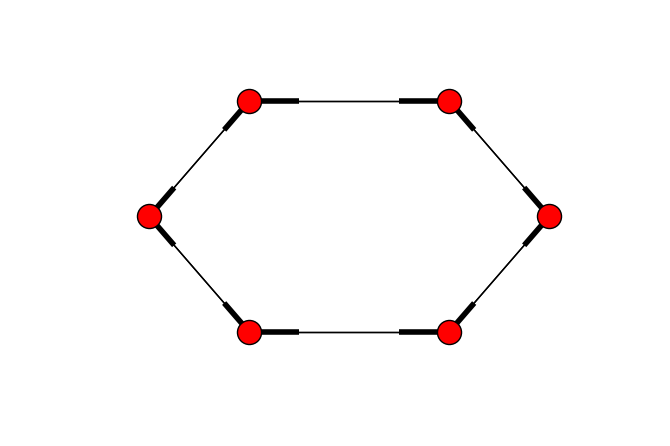

In [29]:
close_ring=True

# Network topology
Gm = mssa.network_AdjMatrix_GG2011_ring(Nsys) # Conection matrix
if close_ring:
    Gm[0,-1]=1
    Gm[-1,0]=1
    
Ni_in = np.nansum(Gm, axis=0) # Number of "in" conections of oscilator i
I = np.diag(np.ones(Nsys)) #identity matrix

Agm = Gm  - Ni_in*I  # Coupling matrix [GG 2011 is (a-2d)]


# Visual inspection of the coupling
fig = plt.figure()
D = nx.DiGraph(Gm) #with d here, the network figure will show correctly if there is connection (Gm) and COUPLING (d).
                    # Because with d=0 there is no coupling!!!!

nx.draw_circular(D)

### Coupled vector field

In [30]:
#A=Matrix([[0,1],[1,0]])
A=Matrix(Gm.astype('int')) # Adjacency matrix (called Gm in the first cell)
I3=Matrix.eye(3)

# Degree (number of connections per node
degree=np.nansum(matrix2numpy(A,dtype='int'), axis=0)
K=diag(*degree)
L=A-K # Laplacian (Note that it is the same as Agm computed in the cell above)


# Symbolic
epsilon=symbols('epsilon') # coupling strength
E=(H*H.T).multiply_elementwise(I3)
LkronE=TensorProduct(L,E)

Fcoupled=F.subs({i:j for i,j in zip(args,args_n)})+epsilon*(LkronE*Matrix(X[1:]))

print 'Arguments used in the vector field F:', {i:j for i,j in zip(args,args_n)}
print 'Comparing the uncoupled and coupled vector fields:'
F,epsilon*(LkronE*Matrix(X[1:])), Fcoupled

Arguments used in the vector field F: {a: 0.45000000000000001, c: 4.0, b: 2.0}
Comparing the uncoupled and coupled vector fields:


⎛⎡    -y₁ - z₁    ⎤, ⎡ε⋅(-2⋅x₁ + x₂ + x₆)⎤, ⎡      ε⋅(-2⋅x₁ + x₂ + x₆) - y₁ - 
⎜⎢                ⎥  ⎢                   ⎥  ⎢                                 
⎜⎢   a⋅y₁ + x₁    ⎥  ⎢ε⋅(-2⋅y₁ + y₂ + y₆)⎥  ⎢   ε⋅(-2⋅y₁ + y₂ + y₆) + x₁ + 0.4
⎜⎢                ⎥  ⎢                   ⎥  ⎢                                 
⎜⎢b + z₁⋅(-c + x₁)⎥  ⎢ε⋅(-2⋅z₁ + z₂ + z₆)⎥  ⎢ε⋅(-2⋅z₁ + z₂ + z₆) + z₁⋅(x₁ - 4.
⎜⎢                ⎥  ⎢                   ⎥  ⎢                                 
⎜⎢    -y₂ - z₂    ⎥  ⎢ε⋅(x₁ - 2⋅x₂ + x₃) ⎥  ⎢      ε⋅(x₁ - 2⋅x₂ + x₃) - y₂ - z
⎜⎢                ⎥  ⎢                   ⎥  ⎢                                 
⎜⎢   a⋅y₂ + x₂    ⎥  ⎢ε⋅(y₁ - 2⋅y₂ + y₃) ⎥  ⎢    ε⋅(y₁ - 2⋅y₂ + y₃) + x₂ + 0.4
⎜⎢                ⎥  ⎢                   ⎥  ⎢                                 
⎜⎢b + z₂⋅(-c + x₂)⎥  ⎢ε⋅(z₁ - 2⋅z₂ + z₃) ⎥  ⎢ε⋅(z₁ - 2⋅z₂ + z₃) + z₂⋅(x₂ - 4.0
⎜⎢                ⎥  ⎢                   ⎥  ⎢                                 
⎜⎢    -y₃ - z₃    ⎥  ⎢ε⋅(x₂ - 2⋅x₃ + x₄) ⎥  ⎢      ε

# Lyapunov spectra estimate

## Simulation parameters

In [21]:
Coup_list_keys

[u'0.0',
 u'0.001',
 u'0.002',
 u'0.003',
 u'0.004',
 u'0.005',
 u'0.006',
 u'0.007',
 u'0.008',
 u'0.009',
 u'0.01',
 u'0.011',
 u'0.012',
 u'0.013',
 u'0.014',
 u'0.015',
 u'0.016',
 u'0.017',
 u'0.018',
 u'0.019',
 u'0.02',
 u'0.021',
 u'0.022',
 u'0.023',
 u'0.024',
 u'0.025',
 u'0.026',
 u'0.027',
 u'0.028',
 u'0.029',
 u'0.03',
 u'0.031',
 u'0.032',
 u'0.033',
 u'0.034',
 u'0.035',
 u'0.036',
 u'0.037',
 u'0.038',
 u'0.039',
 u'0.04',
 u'0.041',
 u'0.042',
 u'0.043',
 u'0.044',
 u'0.045',
 u'0.046',
 u'0.047',
 u'0.048',
 u'0.049',
 u'0.05',
 u'0.051',
 u'0.052',
 u'0.053',
 u'0.054',
 u'0.055',
 u'0.056',
 u'0.057',
 u'0.058',
 u'0.059',
 u'0.06',
 u'0.061',
 u'0.062',
 u'0.063',
 u'0.064',
 u'0.065',
 u'0.066',
 u'0.067',
 u'0.068',
 u'0.069',
 u'0.07',
 u'0.071',
 u'0.072',
 u'0.073',
 u'0.074',
 u'0.075',
 u'0.076',
 u'0.077',
 u'0.078',
 u'0.079',
 u'0.08',
 u'0.081',
 u'0.082',
 u'0.083',
 u'0.084',
 u'0.085',
 u'0.086',
 u'0.087',
 u'0.088',
 u'0.089',
 u'0.09',
 u'0.091',

In [31]:
i_coup=Coup_list_keys[60]
i_coup

u'0.06'

- Trajectory length (s) will be: 1800.0
- Initial condition (x1y1z1 x2y2z2...:
[-2.64210061 -0.46647449  0.30368701 -0.69927402 -3.40706597  0.38923803
  2.86447041 -3.93437899  0.92544269  3.71429305 -1.21578288  2.58973768
  1.00550123  1.39294822  1.2828114  -1.57983364  1.72765774  0.41077862]
- New vector field:



⎡     -0.12⋅x₁ + 0.06⋅x₂ + 0.06⋅x₆ - y₁ - z₁      ⎤
⎢                                                 ⎥
⎢        x₁ + 0.33⋅y₁ + 0.06⋅y₂ + 0.06⋅y₆         ⎥
⎢                                                 ⎥
⎢z₁⋅(x₁ - 4.0) - 0.12⋅z₁ + 0.06⋅z₂ + 0.06⋅z₆ + 2.0⎥
⎢                                                 ⎥
⎢      0.06⋅x₁ - 0.12⋅x₂ + 0.06⋅x₃ - y₂ - z₂      ⎥
⎢                                                 ⎥
⎢        x₂ + 0.06⋅y₁ + 0.33⋅y₂ + 0.06⋅y₃         ⎥
⎢                                                 ⎥
⎢0.06⋅z₁ + z₂⋅(x₂ - 4.0) - 0.12⋅z₂ + 0.06⋅z₃ + 2.0⎥
⎢                                                 ⎥
⎢      0.06⋅x₂ - 0.12⋅x₃ + 0.06⋅x₄ - y₃ - z₃      ⎥
⎢                                                 ⎥
⎢        x₃ + 0.06⋅y₂ + 0.33⋅y₃ + 0.06⋅y₄         ⎥
⎢                                                 ⎥
⎢0.06⋅z₂ + z₃⋅(x₃ - 4.0) - 0.12⋅z₃ + 0.06⋅z₄ + 2.0⎥
⎢                                                 ⎥
⎢      0.06⋅x₃ - 0.12⋅x₄ + 0.06⋅x₅ - y₄ - z₄      ⎥
⎢           

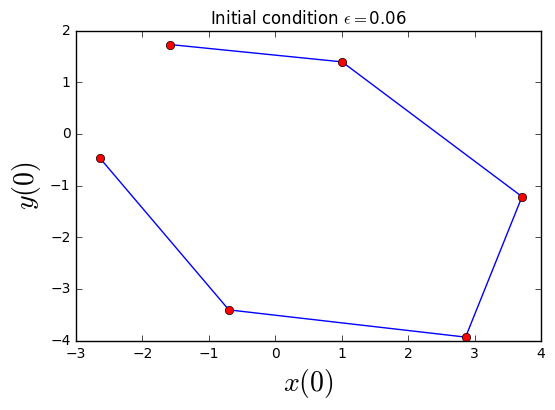

In [32]:
# Simulation parameters
epsilon_n=np.array(i_coup, dtype='float')
dt_n,Transient,T,K=0.02, 3000, 0.6, 3000

# dt_n, integration step
# Transient, transient time to drop away
# T, time evolution before callback (Gram-Schmidt)
# K, Iterations per callback

# Initial condition
ydata=DataFile[i_coup][0,:]
Y0_n= ydata.reshape((3,Nsys)).T.ravel() # xData.reshape((3,3)).T.ravel()
#######################################

Fcoupled_epsilon_n=Fcoupled.subs(epsilon,epsilon_n)

# Plotting initial condition phase space
plt.plot(ydata[:6],ydata[6:12])
plt.plot(ydata[:6],ydata[6:12],'ro')
plt.title('Initial condition $\epsilon=$'+i_coup)
plt.xlabel('$x(0)$',fontsize=20)
plt.ylabel('$y(0)$',fontsize=20)
#################################

print '- Trajectory length (s) will be:',K*T
print '- Initial condition (x1y1z1 x2y2z2...:\n', Y0_n
print '- New vector field:\n'
Fcoupled_epsilon_n


## Plotting the fiducial trajectory

In [68]:
start = time.time() 
# 2 minutes for 6 Rossler systems: dt_n,Transient,T,K=0.02, 0, 0.6, 1000

yt=Simulate(Fcoupled_epsilon_n,Vars,Nsys,
        Y0_n,dt_n,T*K,K,
        Transient)

#How much time I waited?
elapsed = (time.time() - start)
print elapsed, 'seconds\n', elapsed/60, 'minutes' 

print 'yt.shape', yt.shape

415.655236006 seconds
6.92758726676 minutes
yt.shape (30000, 342)


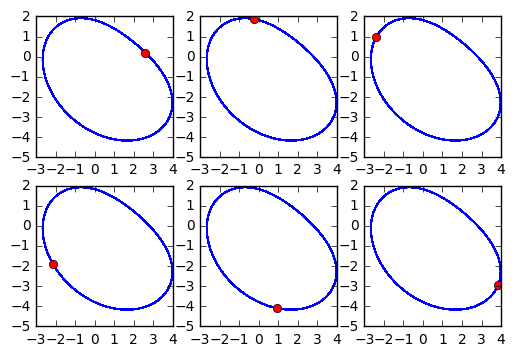

In [69]:
fig=plt.figure()
nr,nc=2,3
k=1
for i in xrange(6):
    ax=fig.add_subplot(nr,nc,k)
    #print 3*i,3*i+3
    ax.plot(yt[:,3*i],yt[:,3*i+1])
    ax.plot(yt[-1,3*i],yt[-1,3*i+1],'ro')
    k+=1

## Computation

In [33]:
start = time.time() 
# 2 minutes for 6 Rossler systems: dt_n,Transient,T,K=0.02, 0, 0.6, 1000

lces=ds.LCEs(Fcoupled_epsilon_n,Vars,Nsys,
        Y0_n,dt_n,T,K,
        Transient)

#How much time I waited?
elapsed = (time.time() - start)
print elapsed, 'seconds\n', elapsed/60, 'minutes' 

1248.54508305 seconds
20.8090847174 minutes


In [35]:
# formating output
res_lces=pd.DataFrame()

res_lces['value']=lces.iloc[-1,:]
res_lces['std']=lces.iloc[-10:,:].std() #uncertainty evaluated with the last 10 values.

print 'Trajectory length (s):',K*T

print 'Lyapunov exponents estimated:\n'
res_lces

Trajectory length (s): 1800.0
Lyapunov exponents estimated:



,value,std
L1_sys1,0.928282,0.000188
L2_sys1,-0.009485,0.000015
L3_sys1,-0.022899,0.000100
L1_sys2,-0.036869,0.000048
L2_sys2,-0.038678,0.000099
L3_sys2,-0.053840,0.000053
L1_sys3,-0.086972,0.000091
L2_sys3,-0.089502,0.000037
L3_sys3,-0.102882,0.000089
L1_sys4,-0.105985,0.000052


In [45]:
# formating output
res_lces=pd.DataFrame()

res_lces['value']=lces.iloc[-1,:]
res_lces['std']=lces.iloc[-10:,:].std() #uncertainty evaluated with the last 10 values.

print 'Trajectory length (s):',K*T

print 'Lyapunov exponents estimated:\n'
res_lces

Trajectory length (s): 600.0
Lyapunov exponents estimated:



,value,std
L1_sys1,0.839880,0.000897
L2_sys1,-0.009161,0.000071
L3_sys1,-0.024226,0.000303
L1_sys2,-0.035543,0.000252
L2_sys2,-0.040627,0.000220
L3_sys2,-0.054106,0.000128
L1_sys3,-0.074724,0.000132
L2_sys3,-0.092128,0.000213
L3_sys3,-0.108468,0.000166
L1_sys4,-0.115435,0.000316


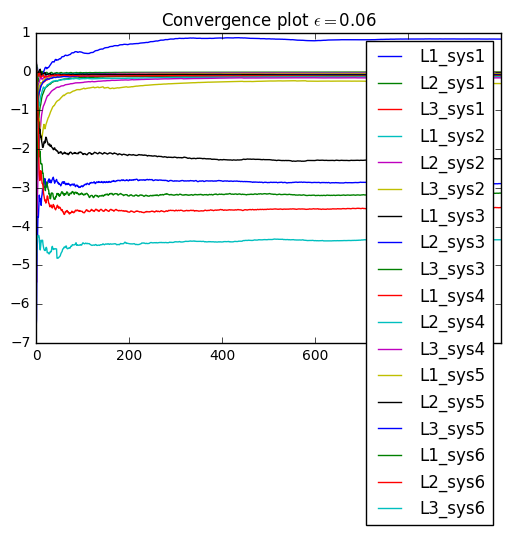

In [46]:
lces.plot(title="Convergence plot $\epsilon=$"+i_coup)

Trajectory length (s): 600.0
Lyapunov exponents estimated:



,value,std
L1_sys1,0.959724,0.000734
L2_sys1,-0.010805,0.000106
L3_sys1,-0.031558,0.000456
L1_sys2,-0.036475,0.000143
L2_sys2,-0.039169,0.000282
L3_sys2,-0.053893,0.000144
L1_sys3,-0.080425,0.000117
L2_sys3,-0.096136,0.000128
L3_sys3,-0.103768,0.000143
L1_sys4,-0.103964,0.000317


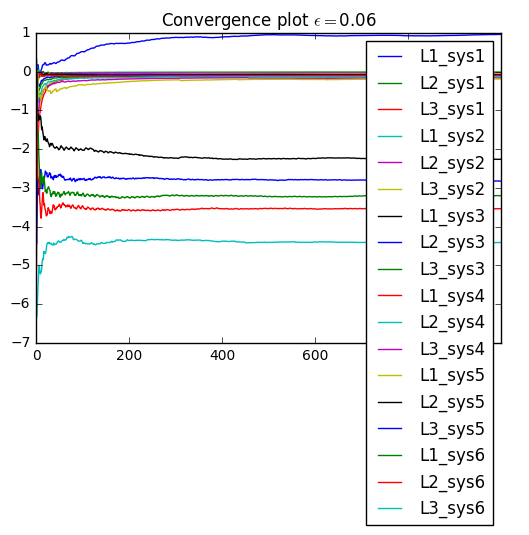

In [31]:
lces.plot(title="Convergence plot $\epsilon=$"+i_coup)

# Plotting what it is being simulated

In [55]:
def RKStep(F,Y0,dt):
    """Runge-Kutta integration
    F is the vector field """
    
    
    k1F=dt*F(Y0)[0] # ravel because the sympy-numpy function returns [[x1],[y1],[z1]]
    
    k2F=dt*F(Y0+k1F/2)[0]
    
    k3F=dt*F(Y0+k2F/2)[0]

    k4F=dt*F(Y0+k3F)[0]

    return Y0+(k1F+2*k2F+2*k3F+k4F)/6.


def gram_schmidt_columns(u):
    """ Returns an orthogonal (and not normalized) base, using
        the Gram-Schmidt method.
        
        Vectors are considered as the columns of the matrix u.
        """
    
    w=np.copy(u)
    v=np.empty_like(w)
    N_vectors=u.shape[1] # number of vectors=number of columns of the matrix u.

    # w1
    w[:,0]=u[:,0]
    v[:,0]=w[:,0]/norm(w[:,0])

    # wk, for k>0
    for k in range(1,N_vectors):
        for i in range(k):
            w[:,k]-=np.dot(u[:,k],v[:,i])*v[:,i]
        v[:,k]=w[:,k]/norm(w[:,k])

    return w     


def Simulate(F,Vars,Nsys,
        Y0_n,dt_n,T,K,
        Transient=0):

    # State vector (symbolic): None x1 y1 z1 x2 y2 z2 x3 y3 z3
    sys_i=[str(i) for i in np.arange(1,Nsys+1)]

    labels_temp=[j+i+' ' for i in sys_i for j in Vars]
    labels_temp='None '+''.join(labels_temp) # none para que X[1] corresponda ao simbolo x1

    # state variables
    X=symbols(labels_temp, real=True)
    vecX=Matrix(X[1:])
    
    # Jacobian
    DF=F.jacobian(vecX)
    
    # Matrix Phi
    Phi=Matrix(np.array(['phi'+str(i)+str(j) 
        for i in range(1,Nsys*3+1)
        for j in range(1,Nsys*3+1)]).reshape(Nsys*3,Nsys*3))
    
    # dPhi/dt
    DPhi=Phi*DF.T


    # Symbolic vector [x ..., y..., z..., phi11, phi12, ...
    vecY0_Phi0=flatten(vecX)+flatten(Phi)

    # Creating the functions (joining F and DPhi)
    f_dphi=lambdify([vecY0_Phi0],(DPhi.T.vec().row_insert(0,F)).T,'numpy') # flattened function [F, DF.Phi]
    
    
    # Simulation ##########################
    
    # Numeric vectors and matrices
    Phi0_n=np.eye(Nsys*3)
    vecY0_Phi0_n=np.hstack((Y0_n,Phi0_n.ravel()))
    yt=vecY0_Phi0_n.copy()
    
    # Transient
    if Transient>0:
        N_n=int(Transient/dt_n)
        

        for i in xrange(N_n-1):
            yt=RKStep(f_dphi,yt,dt_n)
        
        
    # Permanent regime
    N=int(T/dt_n)
    yt_permanent=np.empty((N,yt.shape[0]))
    yt_permanent[0,:]=yt.copy()
    for i in xrange(N-1):
            yt_permanent[i+1,:]=RKStep(f_dphi,yt_permanent[i,:],dt_n)

    
    
    return yt_permanent

# Loading modules

In [8]:
#Básicos
%matplotlib inline

#Símbolo / se torna divisão verdadeira (e não apenas a inteira)
from __future__ import division

import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import time

# specific
from sympy import *
from sympy.physics.quantum import TensorProduct

import h5py
import networkx as nx

#meus modulos
import daVinci03 as leo
import mssa as mssa
import DySys as ds


init_printing()